In [339]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from xgboost import XGBClassifier


In [340]:
from src import Root
root = Root()
root.lib.jupyter_settings()

In [341]:
df = pd.read_csv("../data/housing_resampled.csv")

In [342]:
df['high_value'] = (df['target'] >= 500000).astype(int)
df_backup = df.copy()

In [343]:
print(f"Class distribution:\n{df['high_value'].value_counts()}")
print(f"Percentage of high-value houses: {df['high_value'].mean() * 100:.2f}%")

Class distribution:
high_value
0    21933
1      992
Name: count, dtype: int64
Percentage of high-value houses: 4.33%


In [344]:
df.isna().mean()

longitude                                 0.00
latitude                                  0.00
housing_median_age                        0.00
total_rooms                               0.00
total_bedrooms                            0.01
population                                0.00
households                                0.00
median_income                             0.00
target                                    0.00
ocean_proximity                           0.00
total_rooms_per_households                0.00
total_bedrooms_per_households             0.01
income_per_household                      0.00
total_rooms_not_bedrooms                  0.01
population_per_hosehold                   0.00
income_per_population                     0.00
total_rooms_not_bedrooms_per_households   0.01
distance_to_los_angeles                   0.00
distance_to_san_francisco                 0.00
distance_to_san_diego                     0.00
distance_to_sacramento                    0.00
distance_to_s

In [345]:
df.sample(15)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,target,ocean_proximity,total_rooms_per_households,total_bedrooms_per_households,income_per_household,total_rooms_not_bedrooms,population_per_hosehold,income_per_population,total_rooms_not_bedrooms_per_households,distance_to_los_angeles,distance_to_san_francisco,distance_to_san_diego,distance_to_sacramento,distance_to_silicon_valley,distance_to_fresno,distance_to_santa_barbara,distance_to_san_jose,distance_to_oakland,distance_to_anaheim,distance_to_golden_gate_bridge,distance_to_yosemite_valley,distance_to_death_valley,distance_to_big_sur,high_value
5471,-118.32,33.35,27.00,1675.00,521.00,744.00,331.00,2.16,450000.00,ISLAND,5.06,1.57,0.01,1154.00,2.25,0.00,3.49,48.72,382.74,80.17,402.63,349.45,248.34,108.27,341.01,379.41,40.93,387.17,319.37,233.49,282.57,0
5642,-121.64,39.11,18.00,3212.00,542.00,1817.00,508.00,3.38,92900.00,INLAND,6.32,1.07,0.01,2670.00,3.58,0.00,5.26,396.95,101.43,507.77,37.34,121.15,192.51,341.33,123.15,96.45,418.95,100.01,142.53,312.55,196.41,0
19626,-118.62,34.20,29.00,2421.00,402.00,1120.00,388.00,5.03,244800.00,<1H OCEAN,6.24,1.04,0.01,2019.00,2.89,0.00,5.20,23.82,325.71,132.62,342.31,292.56,187.24,63.40,283.76,321.92,47.58,330.17,258.38,187.10,229.83,0
22767,-117.01,32.67,17.00,2319.00,348.00,1125.00,337.00,5.55,266900.00,NEAR OCEAN,6.88,1.03,0.02,1971.00,3.34,0.00,5.85,119.12,466.32,9.34,479.70,433.20,322.26,196.45,424.35,462.42,96.06,470.79,386.20,266.90,369.47,0
7832,-118.29,33.88,32.00,2307.00,493.00,1754.00,528.00,4.32,232800.00,<1H OCEAN,4.37,0.93,0.01,1814.00,3.32,0.00,3.44,12.19,354.79,103.54,370.64,321.64,214.73,88.77,312.84,350.98,21.76,359.25,284.07,198.63,258.52,0
19508,-118.32,33.33,52.00,2127.00,512.00,733.00,288.00,3.39,300000.00,ISLAND,7.39,1.78,0.01,1615.00,2.55,0.00,5.61,50.09,383.86,79.43,403.88,350.57,249.65,109.23,342.14,380.55,42.08,388.29,320.72,234.79,283.57,0
10430,-117.96,33.68,25.00,2004.00,349.00,1085.00,343.00,4.77,230700.00,<1H OCEAN,5.84,1.02,0.01,1655.00,3.16,0.00,4.83,30.43,377.54,81.07,391.83,344.45,235.09,111.90,335.56,373.61,11.13,382.01,302.38,205.45,281.90,0
5727,-118.41,34.27,38.00,858.00,203.00,1250.00,204.00,2.92,137900.00,<1H OCEAN,4.21,1.00,0.01,655.00,6.13,0.00,3.21,17.80,329.84,129.27,343.67,296.84,187.27,74.22,287.85,325.77,41.25,334.31,256.26,177.07,236.29,0
15716,-122.11,37.39,36.00,1660.00,261.00,655.00,249.00,6.40,500001.00,NEAR BAY,6.67,1.05,0.03,1399.00,2.63,0.01,5.62,316.52,31.53,427.24,88.89,2.89,135.76,245.55,12.80,29.96,340.25,35.90,144.50,291.88,79.14,1
9116,-120.04,34.72,13.00,3942.00,585.00,1542.00,515.00,6.61,500001.00,NEAR OCEAN,7.65,1.14,0.01,3357.00,2.99,0.00,6.52,112.33,249.24,215.74,278.71,216.02,140.14,28.38,208.24,246.69,135.84,253.60,219.09,214.78,146.17,1


<Axes: xlabel='target', ylabel='Count'>

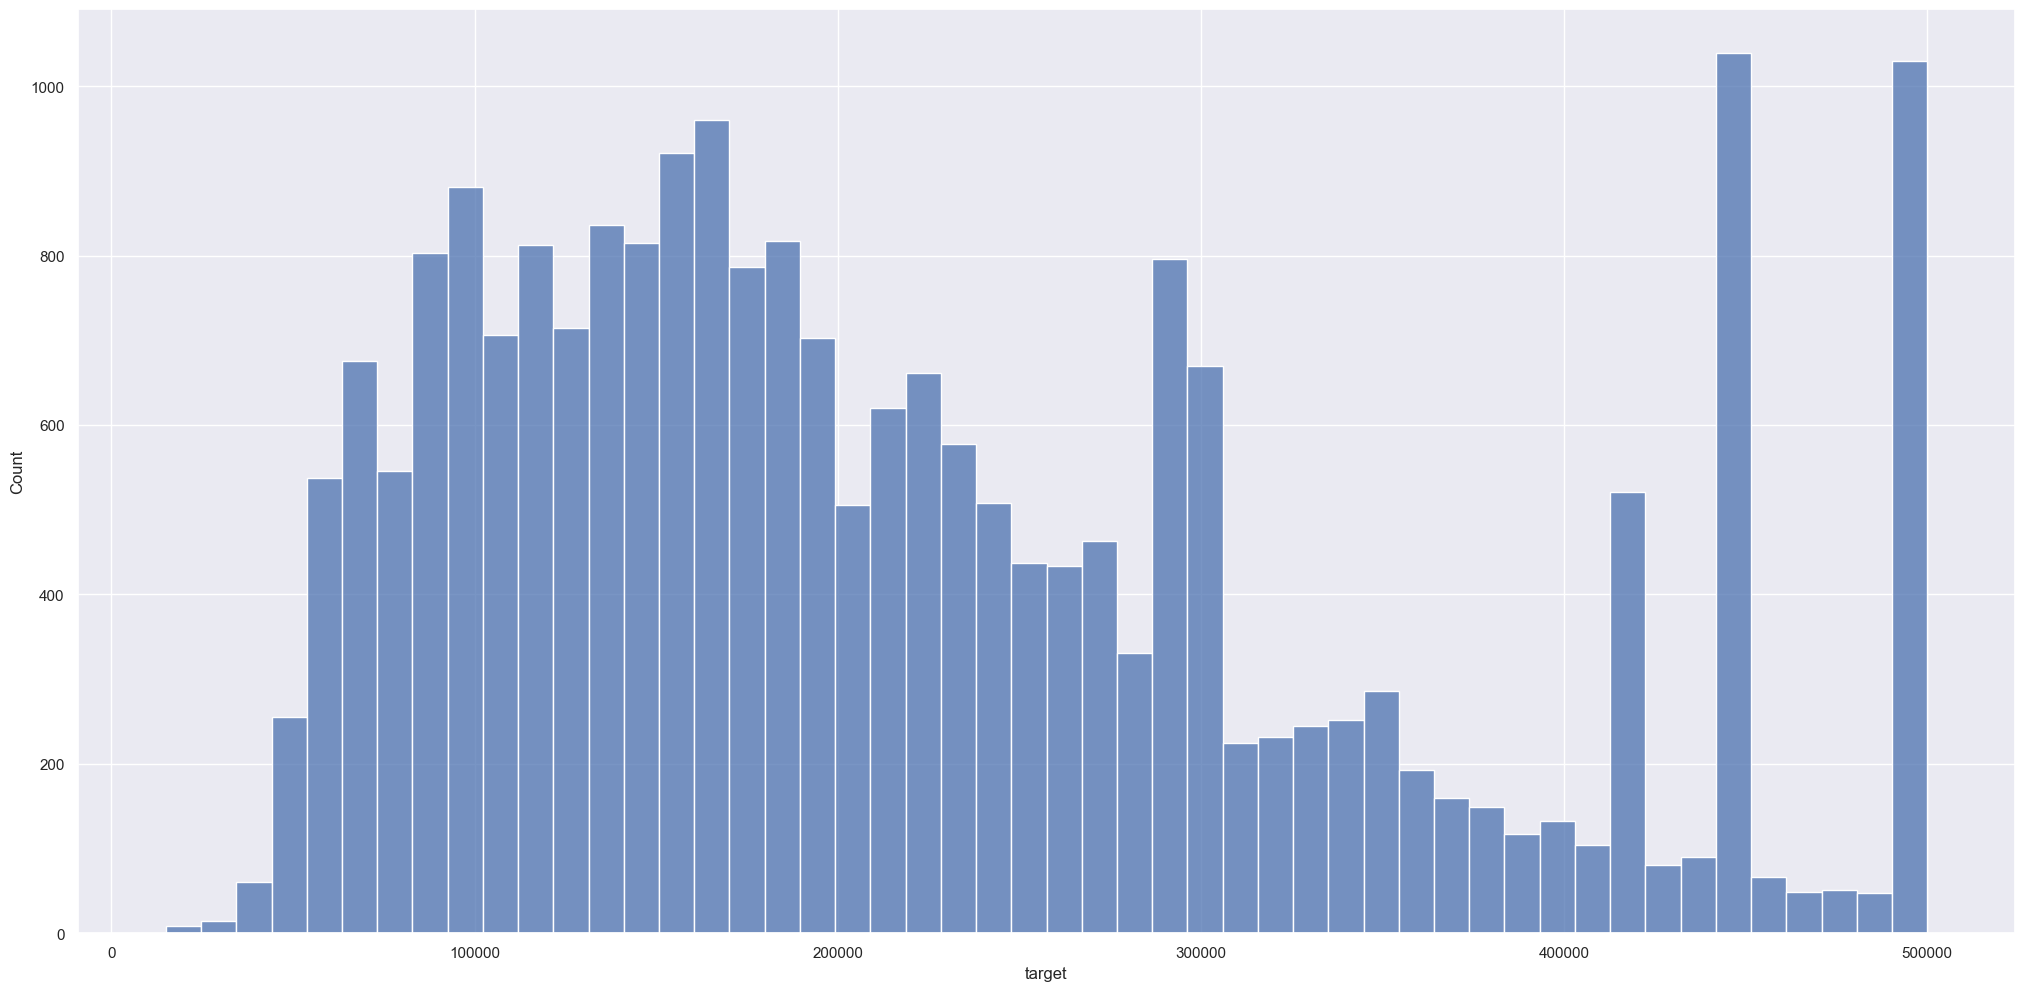

In [ ]:
sns.histplot(df["median_income"], bins = 50)

In [347]:
df["total_bedrooms"].fillna(df["total_bedrooms"].median(), inplace= True)
df["total_bedrooms_per_households"].fillna(df["total_bedrooms_per_households"].median(), inplace= True)

In [348]:
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

In [349]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', 'target',
       'total_rooms_per_households', 'total_bedrooms_per_households',
       'income_per_household', 'total_rooms_not_bedrooms',
       'population_per_hosehold', 'income_per_population',
       'total_rooms_not_bedrooms_per_households', 'distance_to_los_angeles',
       'distance_to_san_francisco', 'distance_to_san_diego',
       'distance_to_sacramento', 'distance_to_silicon_valley',
       'distance_to_fresno', 'distance_to_santa_barbara',
       'distance_to_san_jose', 'distance_to_oakland', 'distance_to_anaheim',
       'distance_to_golden_gate_bridge', 'distance_to_yosemite_valley',
       'distance_to_death_valley', 'distance_to_big_sur', 'high_value',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [350]:
features = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'total_rooms_per_households',
    'total_bedrooms_per_households',
    'income_per_household',
    'total_rooms_not_bedrooms',
    'population_per_hosehold', 
    'income_per_population',
    'total_rooms_not_bedrooms_per_households',
    'distance_to_los_angeles',
    'distance_to_san_francisco',
    'distance_to_san_diego',
    'distance_to_sacramento',
    'distance_to_silicon_valley',
    'distance_to_fresno',
    'distance_to_santa_barbara',
    'distance_to_san_jose',
    'distance_to_oakland',
    'distance_to_anaheim',
    'distance_to_golden_gate_bridge',
    'distance_to_yosemite_valley',
    'distance_to_death_valley',
    'ocean_proximity_INLAND',
    'ocean_proximity_ISLAND',
    'ocean_proximity_NEAR BAY',
    'ocean_proximity_NEAR OCEAN'
]

In [351]:
X = df[features]
y = df['high_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [352]:
rf_clf = XGBClassifier(
    max_depth = 6,
    # gamma = 0.1,
    # alpha = 0.1,
    n_estimators=100, 
    random_state=42, 
    eval_metric='logloss'
)
rf_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [353]:
y_pred = rf_clf.predict(X_test)

print("Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Results:
Accuracy: 0.9764

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4387
           1       0.76      0.67      0.71       198

    accuracy                           0.98      4585
   macro avg       0.87      0.83      0.85      4585
weighted avg       0.98      0.98      0.98      4585




Confusion Matrix:


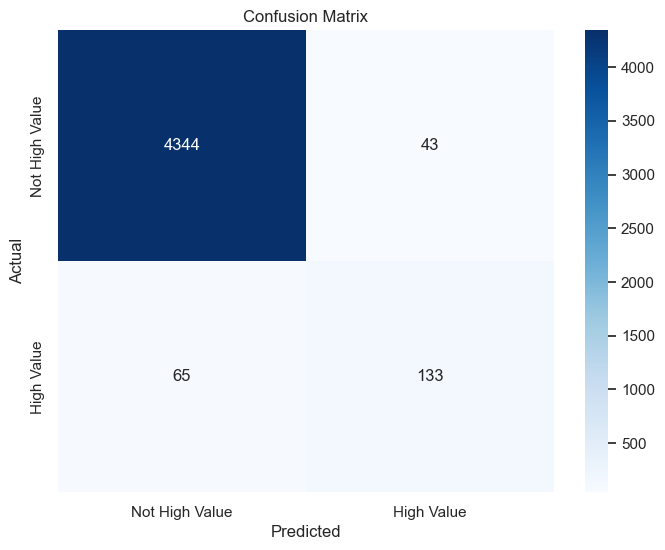

In [354]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not High Value', 'High Value'],
            yticklabels=['Not High Value', 'High Value'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Feature Importance:
                           Feature  Importance
7                    median_income        0.27
28          ocean_proximity_INLAND        0.13
25  distance_to_golden_gate_bridge        0.06
12         population_per_hosehold        0.05
2               housing_median_age        0.05
18          distance_to_sacramento        0.03
31      ocean_proximity_NEAR OCEAN        0.03
24             distance_to_anaheim        0.03
29          ocean_proximity_ISLAND        0.03
26     distance_to_yosemite_valley        0.02


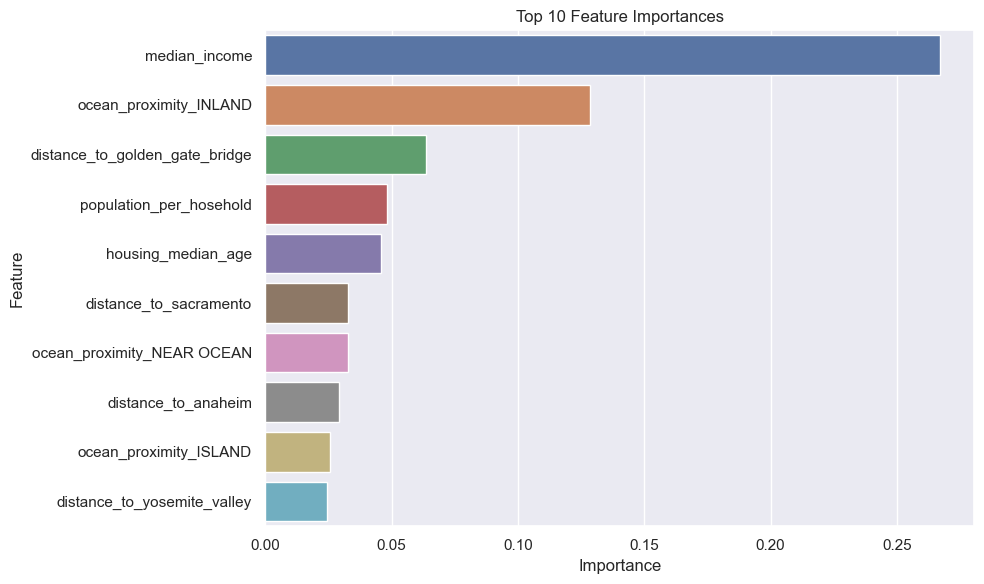

In [355]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()


In [ ]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'alpha': trial.suggest_float('alpha', 0, 1.0),
        'lambda': trial.suggest_float('lambda', 0, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)  # Important for recall
    }
    
    clf = XGBClassifier(
        **param,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False  # Prevent warning
    )
    
    # cross-validation with recall 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='recall')
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')  # maximize recall (find all high value property -> will get predict_proba as a feature later)
study.optimize(objective, n_trials=100)  

print("Best trial:")
trial = study.best_trial
print(f"  Value (Recall): {trial.value:.4f}")

[I 2025-04-24 17:47:11,252] A new study created in memory with name: no-name-155a926a-63b0-45fe-80c8-5a05df0de506
c:\Users\joao.freitas\AppData\Local\anaconda3\envs\housing\lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\joao.freitas\AppData\Local\anaconda3\envs\housing\lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\joao.freitas\AppData\Local\anaconda3\envs\housing\lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\joao

Best trial:
  Value (Recall): 0.8590
  Params:
    n_estimators: 277
    max_depth: 3
    learning_rate: 0.03812332658601561
    subsample: 0.9460123248236605
    colsample_bytree: 0.7368018176375918
    gamma: 2.5642940796763356
    min_child_weight: 6
    alpha: 0.8259053767587397
    lambda: 0.12582662600408762
    scale_pos_weight: 9.740559772888588


In [368]:
best_params

{'n_estimators': 277,
 'max_depth': 3,
 'learning_rate': 0.03812332658601561,
 'subsample': 0.9460123248236605,
 'colsample_bytree': 0.7368018176375918,
 'gamma': 2.5642940796763356,
 'min_child_weight': 6,
 'alpha': 0.8259053767587397,
 'lambda': 0.12582662600408762,
 'scale_pos_weight': 9.740559772888588}

In [357]:
best_params = study.best_params
best_model = XGBClassifier(
    **best_params,
    random_state=42,
    eval_metric='logloss'
)

# Train on the full training set
best_model.fit(X_train, y_train)

# Evaluate on test set

y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4387
           1       0.45      0.83      0.59       198

    accuracy                           0.95      4585
   macro avg       0.72      0.89      0.78      4585
weighted avg       0.97      0.95      0.96      4585


Confusion Matrix:
[[4190  197]
 [  34  164]]


In [358]:
result_df = X.copy()
result_df["is_high_value"] = best_model.predict_proba(X)[:, 1]
result_df["target"] = df_backup["target"]

In [359]:
result_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,total_rooms_per_households,total_bedrooms_per_households,income_per_household,total_rooms_not_bedrooms,population_per_hosehold,income_per_population,total_rooms_not_bedrooms_per_households,distance_to_los_angeles,distance_to_san_francisco,distance_to_san_diego,distance_to_sacramento,distance_to_silicon_valley,distance_to_fresno,distance_to_santa_barbara,distance_to_san_jose,distance_to_oakland,distance_to_anaheim,distance_to_golden_gate_bridge,distance_to_yosemite_valley,distance_to_death_valley,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,is_high_value,target
0,-121.38,38.68,35.00,1565.00,290.00,861.00,277.00,2.48,5.65,1.05,0.01,1275.00,3.11,0.00,4.60,364.20,84.22,475.10,9.18,96.61,159.96,308.72,96.72,77.45,386.28,84.16,114.67,285.05,True,False,False,False,0.00,77000.00
1,-122.07,37.91,33.00,1550.00,277.00,638.00,254.00,3.68,6.10,1.09,0.01,1273.00,2.51,0.01,5.01,341.71,21.23,453.05,55.94,36.11,149.30,274.97,40.77,13.18,365.07,23.12,138.08,298.21,False,False,True,False,0.01,292500.00
2,-117.40,33.95,46.00,2189.00,423.00,866.00,389.00,3.14,5.63,1.09,0.01,1766.00,2.23,0.00,4.54,48.84,385.67,86.39,392.88,353.12,234.93,135.32,343.80,381.06,30.52,390.14,295.77,180.36,True,False,False,False,0.04,111500.00
3,-121.30,38.00,23.00,3706.00,1106.00,3785.00,1019.00,1.78,3.64,1.09,0.00,2600.00,3.71,0.00,2.55,321.77,62.99,433.12,41.54,59.21,120.44,262.91,55.85,54.64,344.38,65.43,96.46,260.65,True,False,False,False,0.00,100000.00
4,-118.32,33.33,52.00,2127.00,512.00,733.00,288.00,3.39,7.39,1.78,0.01,1615.00,2.55,0.00,5.61,50.09,383.86,79.43,403.88,350.57,249.65,109.23,342.14,380.55,42.08,388.29,320.72,234.79,False,True,False,False,0.01,300000.00


In [366]:
result_df.query("target >= 500000")["is_high_value"].median() #0.85423213

0.9143543

In [363]:
result_df.query("target < 500000")["is_high_value"].median() #0.85423213

0.011491638

In [367]:
(
    result_df
    .to_csv("../data/housing_labeled.csv",  index=False)
)